In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import emcee as mcmc
import matplotlib.pyplot as plt
import matplotlib
import corner as corner
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

### Define all input variables.

In [2]:
Freq=[50.0, 78.0, 119.0,  195.0, 235.0, 337.0]
Fwhm_arcmin=[56.0, 39.0, 25.0, 20.0, 29.0, 20.0]
i=5

nu_GHz=Freq[i]
fwhm_arcmin=Fwhm_arcmin[i]

fwhm_rad=np.deg2rad(fwhm_arcmin/60)

nside=512;
npix=hp.nside2npix(nside);
lmax=2*nside;
lmin=2;

# To select whether to include foregrounds and noise.
fg=True
noise=True
half_noise=False
if half_noise==True:
    coeff_n=0.5
else:
    coeff_n=1.0

alpha=[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0];#....in degrees
n=len(alpha)
theta_cmb=np.deg2rad(alpha);#.....degree to radian

### Input the appropriate CMB map and theoretical CMB power spectra of E-mode and B-mode.

In [3]:
map_file_cmb="Instrument_cmb_{}GHz_map.fits".format(nu_GHz)
map_CMB=hp.read_map(map_file_cmb,field=(0,1,2))

if fg==True:
    map_file_fg="Instrument_foreground_{}GHz_map.fits".format(nu_GHz)
    map_FG_original=hp.read_map(map_file_fg,field=(0,1,2))
    FG_cl=hp.anafast(map_FG_original,lmax=lmax)
    map_FG=hp.synfast(FG_cl,nside=nside,lmax=lmax)

if noise==True:
    map_file_noise="Instrument_noise_{}GHz_map.fits".format(nu_GHz)
    map_Noise=hp.read_map(map_file_noise,field=(0,1,2))
else:
    map_Noise=np.zeros(map_CMB.shape)
    
cmb_th_cl_EE,cmb_th_cl_BB=hp.read_cl("Instrument_theory_spectrum.fits")[1:3,lmin:lmax+1]
nmaps=hp.maptype(map_CMB)

### Perform the rotation by $\alpha$ for the CMB map, specifically the Q and U components (2nd and 3rd columns).

In [4]:
map_rot_CMB=np.empty([nmaps,npix,n])
if fg==True:
    map_rot_FG=np.empty([nmaps,npix,n])
else:
    map_rot_FG=np.zeros(map_CMB.shape)

for i in range(n):
    cmb_rot_matrix=np.array([[np.cos(2.0*theta_cmb[i]), -1.0*np.sin(2.0*theta_cmb[i])],
                             [np.sin(2.0*theta_cmb[i]),  np.cos(2.0*theta_cmb[i])]])
    map_rot_CMB[0,:,i]=map_CMB[0,:]
    map_rot_CMB[1,:,i],map_rot_CMB[2,:,i]=np.dot(cmb_rot_matrix,np.array([map_CMB[1,:],map_CMB[2,:]]))
    
    if fg==True:
        fg_rot_matrix=cmb_rot_matrix
        map_rot_FG[0,:,i]=map_FG[0,:]
        map_rot_FG[1,:,i],map_rot_FG[2,:,i]=np.dot(fg_rot_matrix,np.array([map_FG[1,:],map_FG[2,:]]))

Rename the maps arrays as Sky_map_I, Sky_map_Q and Sky_map_U.

In [5]:
Sky_map_I=np.empty([npix,n])
Sky_map_Q=np.empty([npix,n])
Sky_map_U=np.empty([npix,n])
for i in range(n):
    Sky_map_I[:,i]=map_rot_CMB[0,:,i]+map_rot_FG[0,:,i]+coeff_n*map_Noise[0,:]
    Sky_map_Q[:,i]=map_rot_CMB[1,:,i]+map_rot_FG[1,:,i]+coeff_n*map_Noise[1,:]
    Sky_map_U[:,i]=map_rot_CMB[2,:,i]+map_rot_FG[2,:,i]+coeff_n*map_Noise[2,:]

### Convert the I, Q and U maps to the six power spectra in spherical harmonic domain.
Also define the beam function to be multiplied to the theoretical power spectra of CMB. The signal taken as input already has the beam incorporated during simulation.

In [6]:
Cl_EE_O=np.empty([lmax-lmin+1,n])
Cl_BB_O=np.empty([lmax-lmin+1,n])
Cl_EB_O=np.empty([lmax-lmin+1,n])
for i in range(n):
    cl=hp.anafast(np.array([Sky_map_I[:,i],Sky_map_Q[:,i],Sky_map_U[:,i]]),lmax=lmax)# ....the output order is TT, EE, BB, TE, EB, TB

    #  Cl_EE_O, Cl_BB_O, and Cl_EB_O. 'O' denotes that these arrays are observed values. 
    Cl_EE_O[:,i]=cl[1,lmin:lmax+1]
    Cl_BB_O[:,i]=cl[2,lmin:lmax+1]
    Cl_EB_O[:,i]=cl[4,lmin:lmax+1]

b_l_E=hp.gauss_beam(fwhm_rad,lmax=lmax, pol=True)[lmin:,1]#..........b_l_E is same as b_l_B. So, just taking b_l_E

## Define the log Likelihood function  as per https://arxiv.org/abs/1904.12440.

## $ln(L)~=~-\frac{1}{2}\sum_{l=2}^{l_{max}}~\frac{\big[C_l^{EB,O}~-~\frac{tan(4\alpha)}{2}(C_l^{EE,O}-C_l^{BB,O})~-~\frac{sin(4\beta)}{2cos(4\alpha)}(C_l^{EE,CMB,th}-C_l^{BB,CMB,th})b_l^2\big]^2}{\frac{1}{2l+1}~\big[ C_l^{EE,O}C_l^{BB,O}~+~\frac{tan(4\alpha)^2}{2}(\{C_l^{EE,O}\}^2+\{C_l^{BB,O}\}^2)~-~2tan(4\alpha)C_l^{EB,O}(C_l^{EE,O}-C_l^{BB,O}) \big]}$

Define the terms required for the Likelihood function.

In [7]:
def get_terms(Cl_EE_O,Cl_BB_O,Cl_EB_O,cmb_th_cl_EE,cmb_th_cl_BB,b_l_E):
    # 1. Cl_EB_O 
    Num_1=Cl_EB_O

    # 2. (Cl_EE_O - Cl_BB_O)
    Num_2=Cl_EE_O-Cl_BB_O

    # 3. (Cl_EE_CMB_th - Cl_BB_CMB_th)*(b_l_E/B)^2
    Num_3=(cmb_th_cl_EE-cmb_th_cl_BB)*b_l_E*b_l_E

    # 4. Cl_EE_O * Cl_BB_O
    Denom_1=Cl_EE_O*Cl_BB_O

    # 5. (Cl_EE_O)^2 + (Cl_BB_O)^2
    Denom_2=(Cl_EE_O**2)+(Cl_BB_O**2)

    # 6. Cl_EB_O*(Cl_EE_O - Cl_BB_O)
    Denom_3=Num_1*Num_2
    
    cl_terms=[Num_1, Num_2, Num_3, Denom_1, Denom_2, Denom_3]
    
    return cl_terms

Now, define log likelihood with only $\alpha$ as a parameter and value of $\beta$ set to zero.

In [8]:
def log_L(param,cl_terms):
    
    alpha=param
    beta=0.0
    Alpha=np.deg2rad(alpha)
    Beta=np.deg2rad(beta)
    
    l=np.arange(lmin,lmax+1)
    l_=1.0/(2.0*l+1)
    
    tan_a=np.tan(4.0*Alpha)
    cos_a=np.cos(4.0*Alpha)
    sin_b=np.sin(4.0*Beta)
    
    Coeff_num_2=(-0.5)*tan_a
    Coeff_num_3=(-0.5)*(sin_b/cos_a)
    Coeff_denom_2=(0.5)*tan_a*tan_a
    Coeff_denom_3=(-2.0)*tan_a
    
    Num1,Num2,Num3,Denom1,Denom2,Denom3=cl_terms
    
    return (-0.5)*np.sum(np.square(Num1 + Coeff_num_2*Num2 + Coeff_num_3*Num3)/(l_*(Denom1 + Coeff_denom_2*Denom2 + Coeff_denom_3*Denom3)))

Set an approximate range of the parameter $\alpha$ to define the prior and limit the param space. In degrees.

In [9]:
param_min=-4.0*np.ones(n)#[x-1 for x in alpha]#
param_max=4.0*np.ones(n)#[x+1 for x in alpha]#

### Define flat priors and get the posterior distribution to use instead of log_L. Define the posterior as prior * likelihood => log_posterior = log_prior + log_likelihood.

In [10]:
def log_prior(param,param_min,param_max):
    if not param_min < param < param_max:
        log_prob=-np.inf
    else:
        log_prob=0.0
    return log_prob

In [11]:
def log_posterior(param,cl_terms,param_min,param_max):
    lp=log_prior(param,param_min,param_max)
    if np.isfinite(lp):
        return lp + log_L(param,cl_terms)
    return -np.inf

## Define the arguments needed to run emcee MCMC estimation of $\alpha$ and run the sampler.

In [12]:
ndim, nwalkers = 1, 100
niter = 10000
#np.random.seed(123)

### Run the sampler

In [13]:
sampler_all=[]
sampler_flat=[]
thin, discard = 1, 1000
for i in range(n):
    p0 = param_min[i]+ (param_max[i]-param_min[i])*np.random.rand(nwalkers)      #...make sure the starting points are within the expected range -> easier convergence.
    p0 = p0.reshape((p0.shape[0],1))                                             #...To make the array initiating-points the right dimension to input into the run_mcmc function
    
    cl_terms=get_terms(Cl_EE_O[:,i],Cl_BB_O[:,i],Cl_EB_O[:,i],cmb_th_cl_EE,cmb_th_cl_BB,b_l_E)
    
    sampler = mcmc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[cl_terms,param_min[i],param_max[i]])
    sampler.run_mcmc(p0, niter, progress=True);
    
    sampler_all.append(sampler.get_chain(thin=thin, discard=discard)[:, :, 0])
    sampler_flat.append(sampler.get_chain(thin=thin, discard=discard,flat=True))

 16%|█▌        | 1581/10000 [00:07<00:36, 230.53it/s]<ipython-input-8-f1e7eaa34258>:22: RuntimeWarning: divide by zero encountered in true_divide
  return (-0.5)*np.sum(np.square(Num1 + Coeff_num_2*Num2 + Coeff_num_3*Num3)/(l_*(Denom1 + Coeff_denom_2*Denom2 + Coeff_denom_3*Denom3)))
100%|██████████| 10000/10000 [00:46<00:00, 214.19it/s]


### Plot the normal and corner plot of the result.

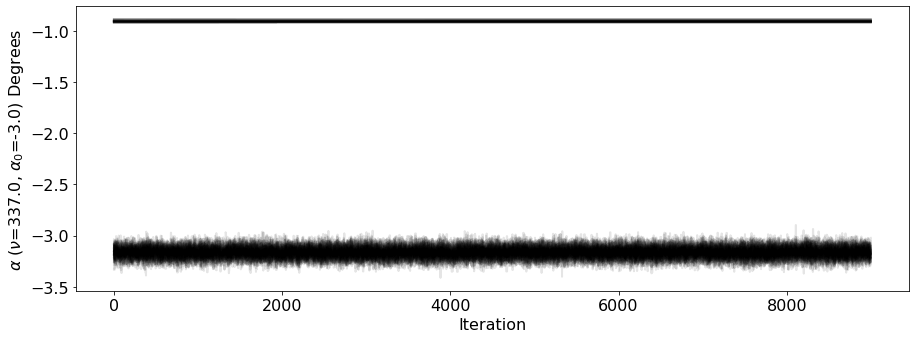

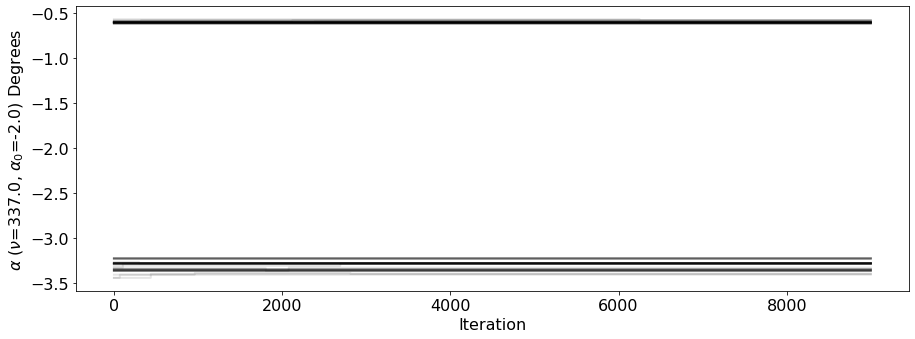

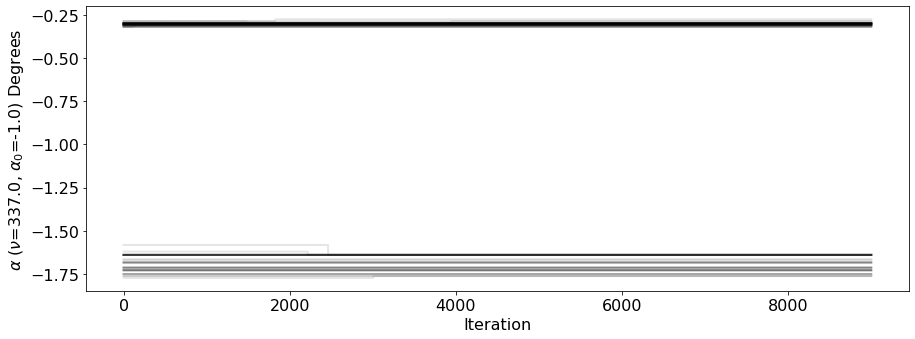

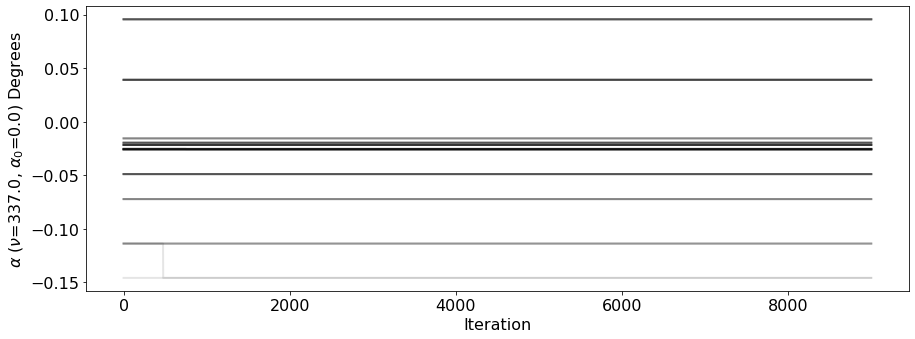

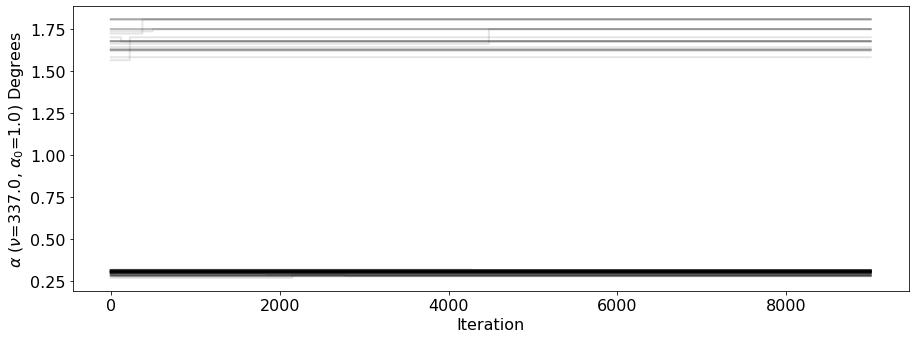

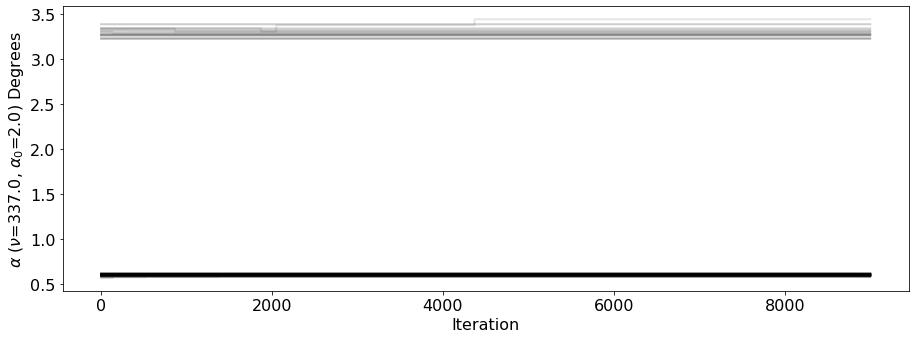

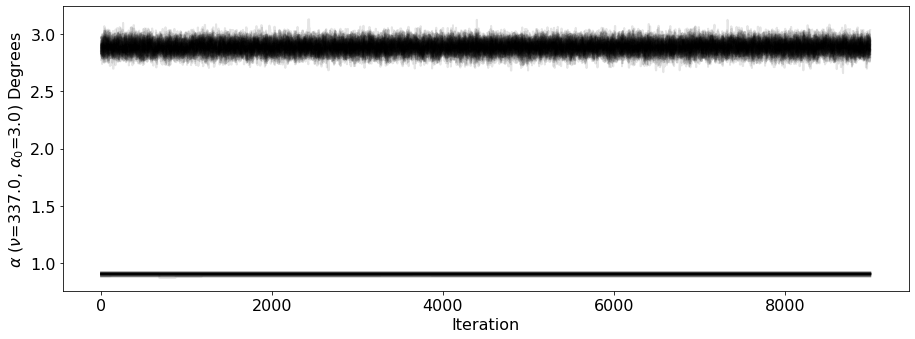

In [14]:
for i in range(n):
    param_name = r'$\alpha$ '+r'($\nu$={}, $\alpha_0$={})'.format(nu_GHz,alpha[i])+' Degrees'#...the r is required for the latex commands to be recognized
    
    plt.figure(figsize=(13, 5))
    plt.plot(sampler_all[i], color='black', alpha=0.1, lw=2)#...the array has dim [niter-discard, nwalkers, ndim]
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.tight_layout()

<Figure size 1080x360 with 0 Axes>

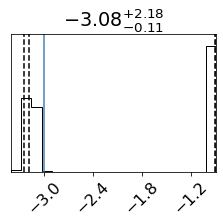

<Figure size 1080x360 with 0 Axes>

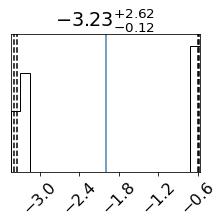

<Figure size 1080x360 with 0 Axes>

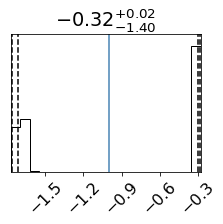

<Figure size 1080x360 with 0 Axes>

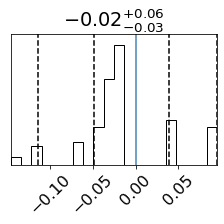

<Figure size 1080x360 with 0 Axes>

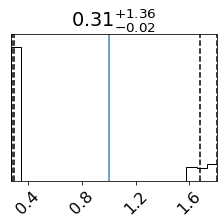

<Figure size 1080x360 with 0 Axes>

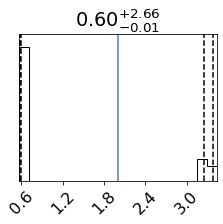

<Figure size 1080x360 with 0 Axes>

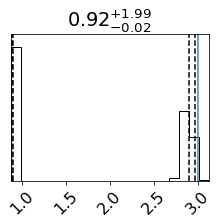

In [15]:
for i in range(n):
    plt.figure(figsize=(15,5))
    fig=corner.corner(sampler_flat[i], quantiles=(0.025,0.16, 0.84,0.975), show_titles=True,truths=[alpha[i]]);
    plt.tight_layout()

### Get the 1-$\sigma$ errorbars and plot out the output/estimated value against input value.

1-sigma:  [-0.11321139718865769, 2.1750503401357335]
alpha estimate (alpha_in = -3.0)=  -3.0800079245737964

1-sigma:  [-0.12425094186793739, 2.62328561291202]
alpha estimate (alpha_in = -2.0)=  -3.2262858827603385

1-sigma:  [-1.3971507187008587, 0.019531286014078164]
alpha estimate (alpha_in = -1.0)=  -0.3167372863270478

1-sigma:  [-0.02720116249466909, 0.06079056561896522]
alpha estimate (alpha_in = 0.0)=  -0.021739796273307688

1-sigma:  [-0.015650099050706023, 1.3623993015976972]
alpha estimate (alpha_in = 1.0)=  0.31427041160440333

1-sigma:  [-0.014100363351882028, 2.659147943141397]
alpha estimate (alpha_in = 2.0)=  0.6011278678671585

1-sigma:  [-0.015236037594079543, 1.9919547717464716]
alpha estimate (alpha_in = 3.0)=  0.915936920088652



Text(0, 0.5, '$\\alpha_{estimate}$')

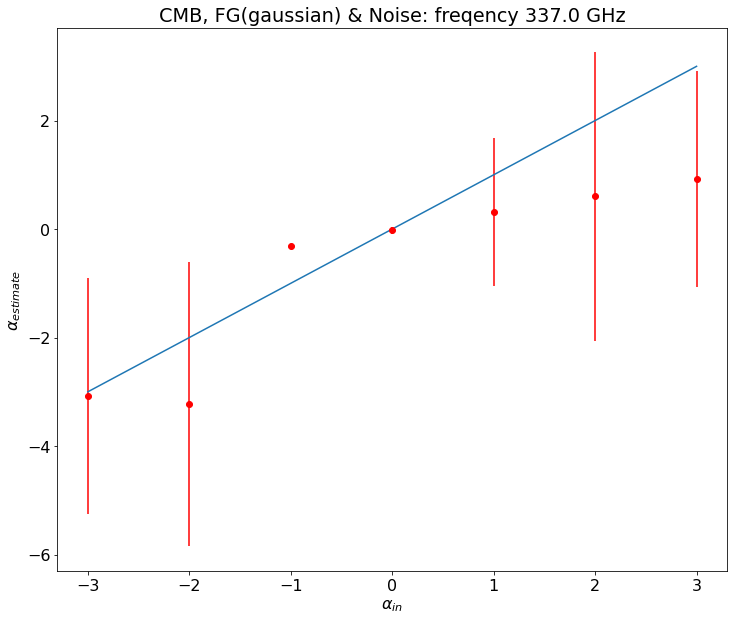

In [16]:
err=[]
alpha_out=[]

if fg!=True and noise!=True:
    title='Only CMB: freqency {} GHz'
elif fg==True and noise!=True:
    title='CMB & FG(gaussian): freqency {} GHz'
elif fg!=True and noise==True:
    title='CMB & Noise: freqency {} GHz'
else:
    title='CMB, FG(gaussian) & Noise: freqency {} GHz'
if half_noise==True:
    title+=': 0.5*Noise'
    
plt.figure(figsize=(12, 10))
for i in range(n):
    q_2_5, q_16, q_50, q_84, q_97_5 = corner.quantile(sampler_flat[i], [0.025,0.16, 0.5, 0.84,0.975]) # one-sigma values and the mean
    one_sigma_down, one_sigma_up = q_16-q_50, q_84-q_50
    alpha_estimate=q_50
    print('1-sigma: ',[one_sigma_down, one_sigma_up])
    print("alpha estimate (alpha_in = {})= ".format(alpha[i]),alpha_estimate)
    print("")
    
    plt.errorbar(alpha[i],alpha_estimate,fmt='ro',yerr=one_sigma_up)
    
    err.append(one_sigma_up)
    alpha_out.append(alpha_estimate)
    
#x=np.linspace(np.min(param_min),np.max(param_max),100)
x=np.linspace(-3.0,3.0,100)
plt.plot(x,x,'-')
plt.title(title.format(nu_GHz))
plt.xlabel(r'$\alpha_{in}$')
plt.ylabel(r'$\alpha_{estimate}$')

Text(0, 0.5, 'Error')

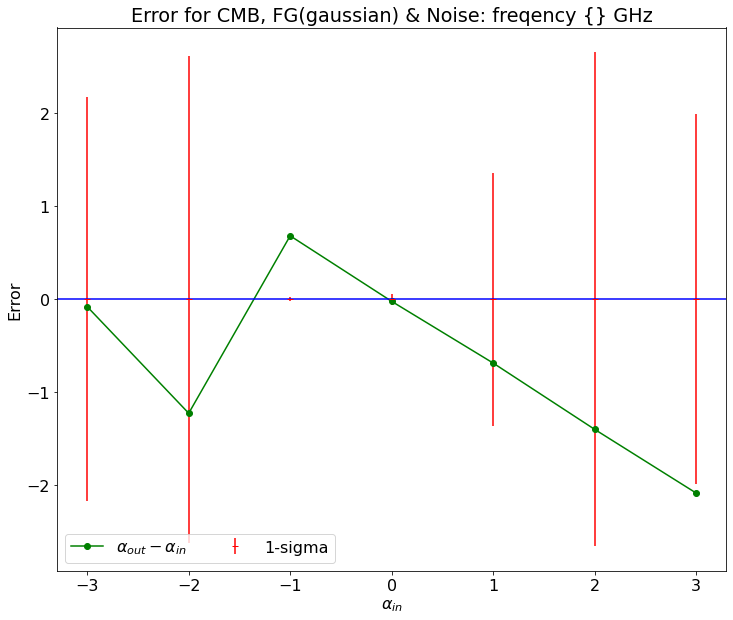

In [17]:
plt.figure(figsize=(12, 10))
plt.errorbar(alpha,np.zeros(n),fmt='r_',yerr=err,label='1-sigma')
plt.plot(alpha,np.array(alpha_out)-np.array(alpha),'go-',label=r'$\alpha_{out}-\alpha_{in}$')
plt.axhline(y = 0.0, color = 'b', linestyle = '-')
plt.legend(loc='lower left', ncol=2)
plt.title("Error for "+title)
plt.xlabel(r'$\alpha_{in}$')
plt.ylabel("Error")

In [18]:
err

[2.1750503401357335,
 2.62328561291202,
 0.019531286014078164,
 0.06079056561896522,
 1.3623993015976972,
 2.659147943141397,
 1.9919547717464716]

In [19]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

i=4
for i in range(n):
    cl_terms=get_terms(Cl_EE_O[:,i],Cl_BB_O[:,i],Cl_EB_O[:,i],cmb_th_cl_EE,cmb_th_cl_BB,b_l_E)
    alpha_=alpha[i]

    #np.random.seed(42)
    nll = lambda *args: -log_L(*args)
    bounds=Bounds(-180.0,180.0)
    initial = np.array(alpha_) + 0.1 * np.random.randn(1)
    soln = minimize(nll, initial, args=(cl_terms),bounds=bounds)
    alpha_ml = soln.x
    x0 = np.linspace(0, 10, 500)

    #A = np.vander(x, 2)
    #C = np.diag(yerr * yerr)
    #ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    #cov = np.linalg.inv(ATA)
    #w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))

    print("Maximum likelihood estimate for alpha_in={} :".format(alpha_))
    print("alpha = {}".format(alpha_ml))
    print("")
    #print("beta = {0:.3f}".format(beta_ml))


Maximum likelihood estimate for alpha_in=-3.0 :
alpha = [-3.16442794]

Maximum likelihood estimate for alpha_in=-2.0 :
alpha = [-2.25598942]

Maximum likelihood estimate for alpha_in=-1.0 :
alpha = [-1.65006212]

Maximum likelihood estimate for alpha_in=0.0 :
alpha = [-0.04893914]

Maximum likelihood estimate for alpha_in=1.0 :
alpha = [0.28419314]

Maximum likelihood estimate for alpha_in=2.0 :
alpha = [1.79703779]

Maximum likelihood estimate for alpha_in=3.0 :
alpha = [2.88722436]

